In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import zscore

In [220]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data"
WAFFLE_DATASET_PATH = f"{_BASE_URL}/WaffleDivorce.csv"

In [221]:
# Load data
divorce_data = pd.read_csv(WAFFLE_DATASET_PATH, sep=";")

In [222]:
divorce_data[["Divorce_z", "Marriage_z", "MedianAgeMarriage_z"]] = divorce_data[
    ["Divorce", "Marriage", "MedianAgeMarriage"]
].apply(zscore)

## Bivariate model

In [255]:
with pm.Model() as McElreth_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * divorce_data["MedianAgeMarriage_z"])
    divorce_z = pm.Normal(
        "Divorce_z", mu=mu, sd=sigma, observed=divorce_data["Divorce_z"].values
    )

with McElreth_5_1:
    trace = pm.sample(1000, tune=1000)
    prior = pm.sample_prior_predictive(1000)
    posterior_predictive = pm.sample_posterior_predictive(trace)

pm_data = az.from_pymc3(
    trace=trace, prior=prior, posterior_predictive=posterior_predictive,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, bA, a]
100%|██████████| 2000/2000 [00:03<00:00, 513.78it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f38c2d4eb10>,
      dtype=object)

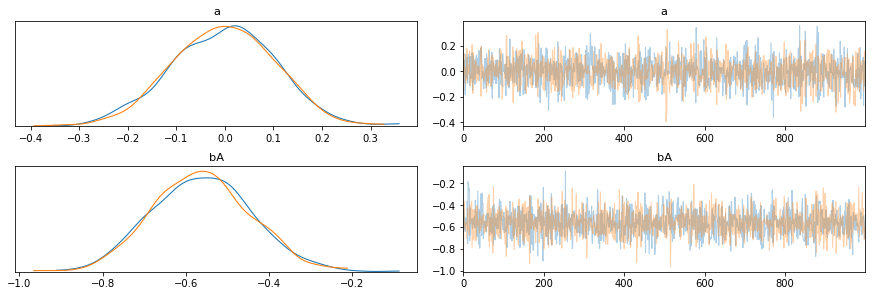

In [256]:
az.plot_trace(pm_data, var_names=["a", "bA"])

## Multiple Regression

Text(0, 0.5, 'Divorce Rate (z-score)')

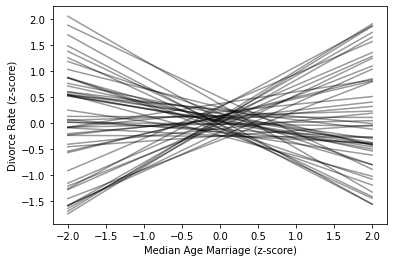

In [257]:
fig, ax = plt.subplots()

# plot over a 4 std range of the dependent variable.
# question: isn't this essentially performing emperical
# bayes? .. wouldn't we get the same result if we computed
# the standard deviation of our sample and then used that to
# set the priors.
x = np.linspace(-2, 2, 50)

for a, ba in zip(
    pm_data.prior["a"].values.squeeze()[:50], pm_data.prior["bA"].values.squeeze()[:50]
):
    y = a + ba * x
    ax.plot(x, y, c="black", alpha=0.4)
ax.set_xlabel("Median Age Marriage (z-score)")
ax.set_ylabel("Divorce Rate (z-score)")

# I'm not sure if this is really a helpfull plot - I think
# I would be better able to evaluate if this is a reasonable
# prior if the data were in non-standardized units.

In [269]:
mu_hat = pm_data.posterior["mu"].mean(axis=1)[0]
mu_hpd = az.hpd(pm_data.posterior["mu"], credible_interval=0.89)[:, :, 0]

In [271]:
divorce_predictive_hat = pm_data.posterior_predictive["Divorce_z"].mean(axis=1)[0]
divorce_hpd = az.hpd(
    pm_data.posterior_predictive["Divorce_z"].values.squeeze(), credible_interval=0.89
)[:, :, 0]

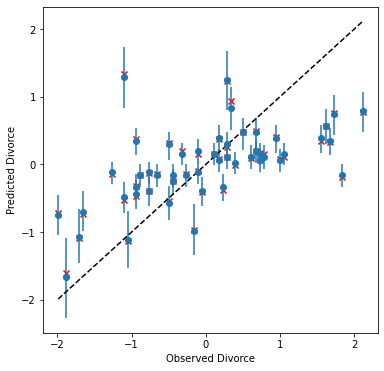

In [272]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.errorbar(
    divorce_data["Divorce_z"].values,
    mu_hat,
    yerr=np.abs(mu_hat.values - mu_hpd.T),
    fmt="C0o",
)
ax.scatter(
    divorce_data["Divorce_z"].values, divorce_predictive_hat, marker="x", color="r"
)

min_x, max_x = divorce_data["Divorce_z"].min(), divorce_data["Divorce_z"].max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

ax.set_ylabel("Predicted Divorce")
ax.set_xlabel("Observed Divorce");